In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add project root to system path for config import
SRC = Path("__file__").resolve().parents[1]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import config as cfg

In [10]:
final_data_path = cfg.FIN_MERGED / "model_ready_dataset.parquet"
print(f"Loading final dataset from: {final_data_path}")
try:
    df = pd.read_parquet(final_data_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: The file {final_data_path.name} was not found.")
    exit()

# Ensure date column is datetime for manipulation
df['date'] = pd.to_datetime(df['date'])

Loading final dataset from: C:\Air pollution london\data\final\aq_traffic\model_ready_dataset.parquet
Dataset loaded successfully.


In [12]:
print("\n=== DATA OVERVIEW ===")
print(f"Shape of the dataset: {df.shape}")
print("\nColumn data types and non-null counts:")
df.info()

print("\n--- Summary Statistics for Numeric Columns ---")
# Use .describe() for a statistical summary
print(df.describe().to_string())


=== DATA OVERVIEW ===
Shape of the dataset: (257931, 18)

Column data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257931 entries, 0 to 257930
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype                        
---  ------                --------------   -----                        
 0   date                  257931 non-null  datetime64[ns, Europe/London]
 1   SiteID                257931 non-null  object                       
 2   NO2                   249674 non-null  float64                      
 3   PM2.5                 203812 non-null  float64                      
 4   temperature_2m        257931 non-null  float64                      
 5   wind_speed_10m        257931 non-null  float64                      
 6   cloud_cover           257931 non-null  float64                      
 7   relative_humidity_2m  257931 non-null  float64                      
 8   precipitation         257931 non-null  float64


--- Analyzing Target Variables: NO2 and PM2.5 ---


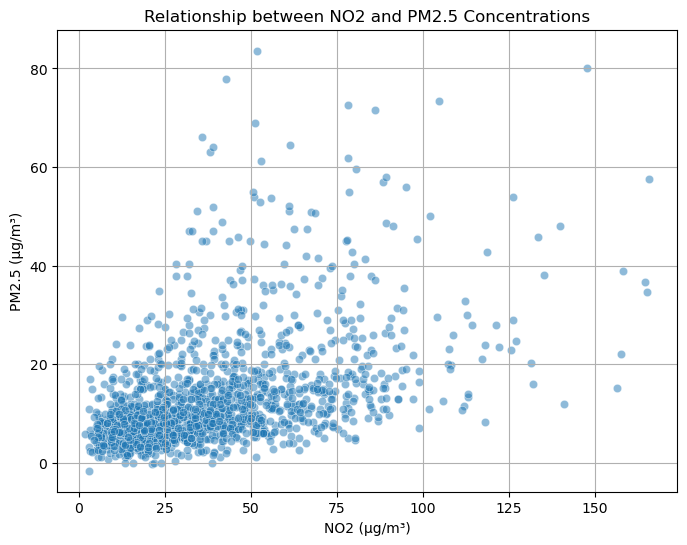


This plot shows if NO2 and PM2.5 concentrations tend to rise and fall together. We expect a positive correlation.


In [14]:
print("\n--- Analyzing Target Variables: NO2 and PM2.5 ---")

# Plot 1: Relationship between NO2 and PM2.5
# We'll use a sample to avoid overplotting
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df.sample(2000), x='NO2', y='PM2.5', alpha=0.5)
plt.title('Relationship between NO2 and PM2.5 Concentrations')
plt.xlabel('NO2 (µg/m³)')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()
print("\nThis plot shows if NO2 and PM2.5 concentrations tend to rise and fall together. We expect a positive correlation.")

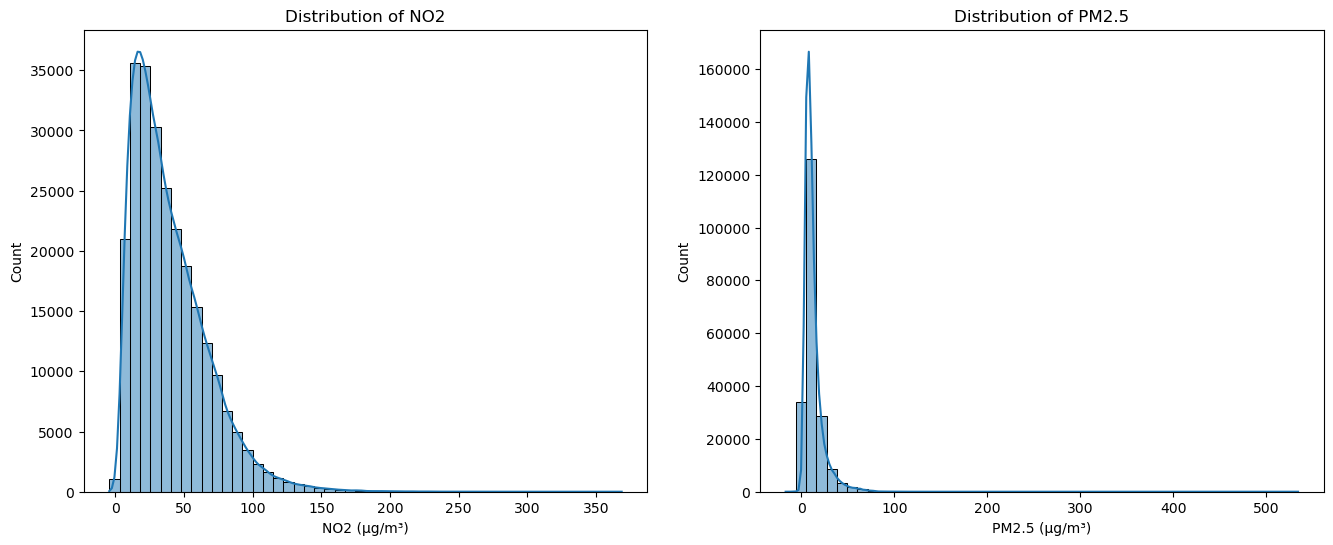


These histograms show the frequency of different pollution levels.


In [16]:
# Plot 2: Distribution of Target Variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['NO2'].dropna(), bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of NO2')
axes[0].set_xlabel('NO2 (µg/m³)')

sns.histplot(df['PM2.5'].dropna(), bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of PM2.5')
axes[1].set_xlabel('PM2.5 (µg/m³)')
plt.show()
print("\nThese histograms show the frequency of different pollution levels.")


--- Analyzing Feature Relationships with NO2 ---


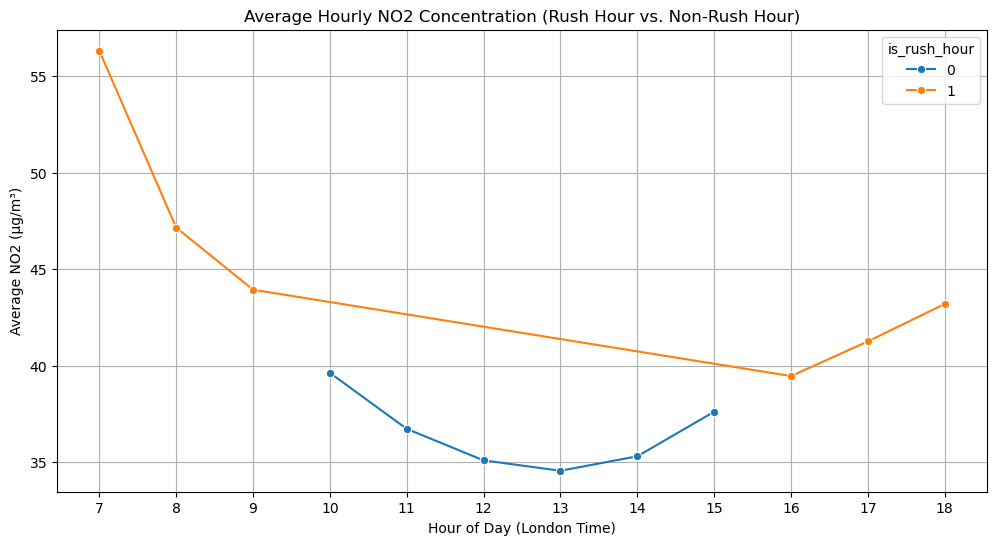


This clearly visualizes the morning and evening pollution peaks and confirms the 'is_rush_hour' feature is impactful.


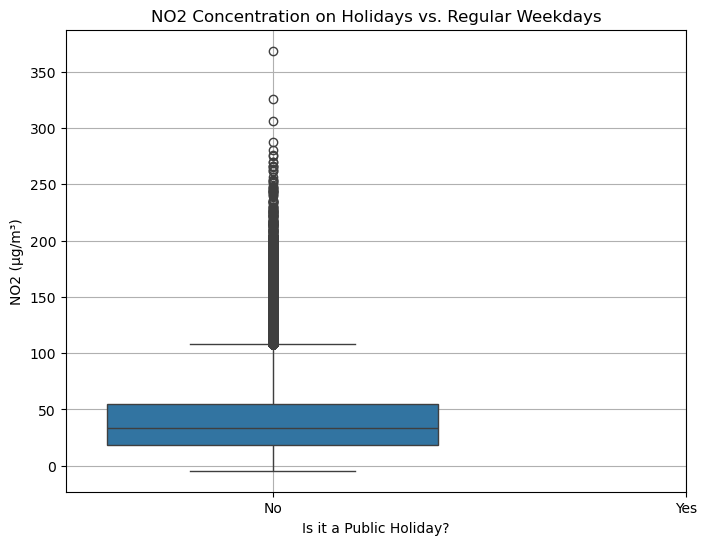


This plot checks if pollution levels are typically lower on public holidays.


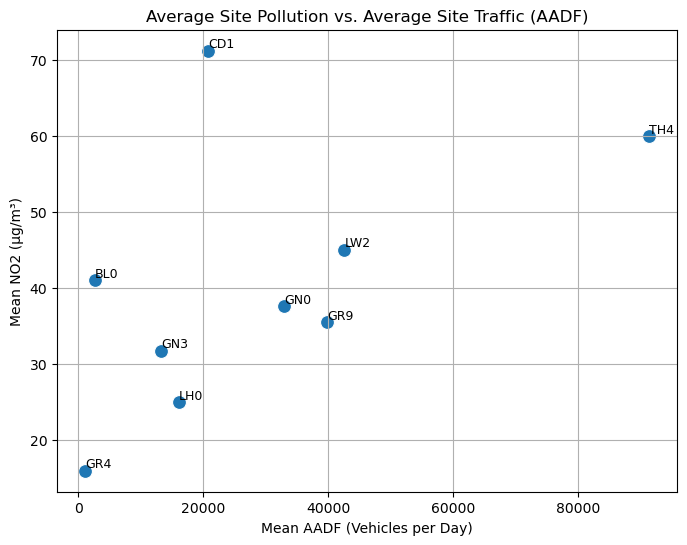


This plot confirms if sites located in busier areas (higher AADF) tend to have higher pollution.


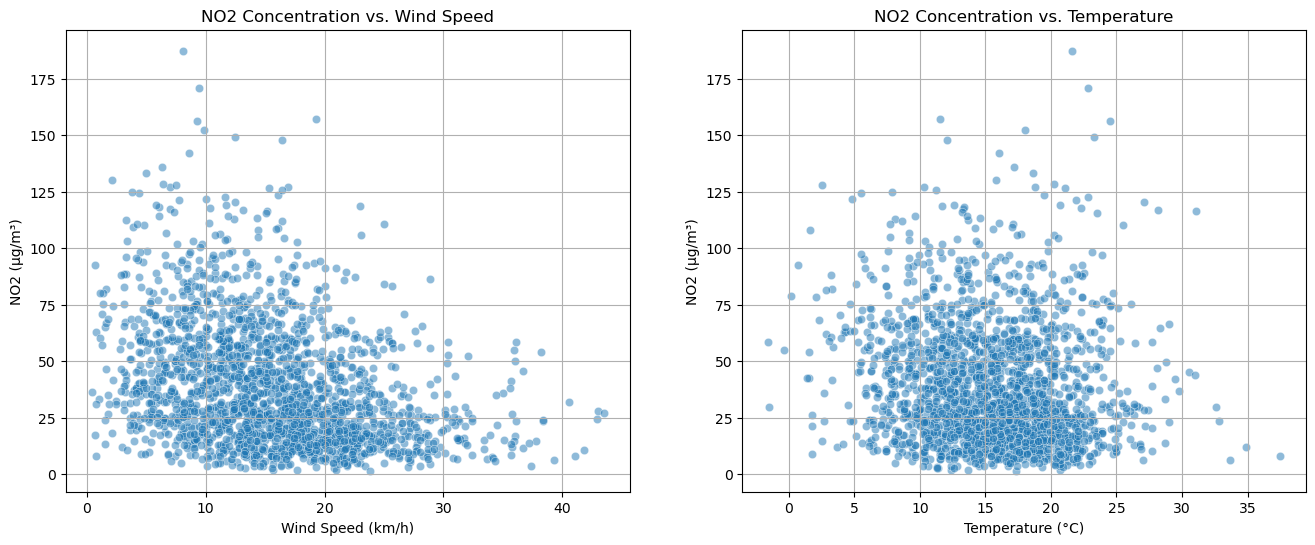


These scatter plots explore the relationship between weather and pollution. We expect higher wind speeds to lead to lower pollution.


In [20]:
# --- 4. Feature Relationship Analysis ---
print("\n--- Analyzing Feature Relationships with NO2 ---")

# Plot 3: Diurnal (Hourly) Pattern of NO2 vs. Rush Hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='NO2', hue='is_rush_hour', errorbar=None, marker='o')
plt.title('Average Hourly NO2 Concentration (Rush Hour vs. Non-Rush Hour)')
plt.xlabel('Hour of Day (London Time)')
plt.ylabel('Average NO2 (µg/m³)')
plt.grid(True)
plt.xticks(np.arange(7, 19))
plt.show()
print("\nThis clearly visualizes the morning and evening pollution peaks and confirms the 'is_rush_hour' feature is impactful.")

# Plot 4: Impact of Holidays
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_holiday', y='NO2')
plt.title('NO2 Concentration on Holidays vs. Regular Weekdays')
plt.xlabel('Is it a Public Holiday?')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('NO2 (µg/m³)')
plt.grid(True)
plt.show()
print("\nThis plot checks if pollution levels are typically lower on public holidays.")


# Plot 5: Impact of AADF (Average Traffic Volume)
# Let's see if sites with higher average traffic have higher average pollution.
site_avg = df.groupby('SiteID').agg(
    avg_no2=('NO2', 'mean'),
    avg_aadf=('aadf_vehicle_count', 'mean')
).dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=site_avg, x='avg_aadf', y='avg_no2', s=100)
# Add labels to points using .iloc for safe positional access
for i in range(site_avg.shape[0]):
    plt.text(site_avg.iloc[i]['avg_aadf'], site_avg.iloc[i]['avg_no2'], site_avg.index[i], fontsize=9, ha='left', va='bottom')
plt.title('Average Site Pollution vs. Average Site Traffic (AADF)')
plt.xlabel('Mean AADF (Vehicles per Day)')
plt.ylabel('Mean NO2 (µg/m³)')
plt.grid(True)
plt.show()
print("\nThis plot confirms if sites located in busier areas (higher AADF) tend to have higher pollution.")


# Plot 6: Impact of Weather (Wind Speed and Temperature)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Using a sample for scatter plots to keep them readable
df_sample = df.dropna(subset=['NO2', 'wind_speed_10m', 'temperature_2m']).sample(2000)

sns.scatterplot(data=df_sample, x='wind_speed_10m', y='NO2', alpha=0.5, ax=axes[0])
axes[0].set_title('NO2 Concentration vs. Wind Speed')
axes[0].set_xlabel('Wind Speed (km/h)')
axes[0].set_ylabel('NO2 (µg/m³)')
axes[0].grid(True)

sns.scatterplot(data=df_sample, x='temperature_2m', y='NO2', alpha=0.5, ax=axes[1])
axes[1].set_title('NO2 Concentration vs. Temperature')
axes[1].set_xlabel('Temperature (°C)')
axes[1].set_ylabel('NO2 (µg/m³)')
axes[1].grid(True)
plt.show()
print("\nThese scatter plots explore the relationship between weather and pollution. We expect higher wind speeds to lead to lower pollution.")